# Motion


In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
plt.rcParams["figure.facecolor"]=(1,1,1,1)

In this notebook we get familiar with a few motion analysis methods.

## Background subtraction
Background subtraction can be used to detect moving objects from a stationary camera.

### Background frame

Background subtraction requires a background model, and the simplest way to derive it is to calculate an average image over several frames. In the next example, we create a background frame by averaging over all the frames in a video file and visualize it.

In [3]:
cap = cv2.VideoCapture('videos/vtest.avi')

In [4]:
ret, frame = cap.read()
backgr = np.zeros(frame.shape, dtype=np.float32)
i = 0
while ret:
    backgr += frame
    ret, frame = cap.read()
    i += 1
backgr /= i

In [5]:
cap.release()

(-0.5, 767.5, 575.5, -0.5)

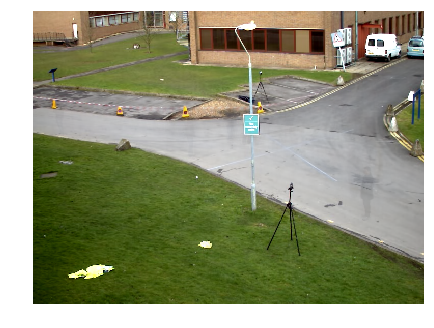

In [6]:
plt.figure(figsize=(7,7))
plt.imshow(cv2.cvtColor(backgr.astype(np.uint8),cv2.COLOR_BGR2RGB))
plt.axis('off')

Then, we take the first frame of the video shown below and use it as an input to detect the moving objects (changed pixels).

In [7]:
cap = cv2.VideoCapture('videos/vtest.avi')

In [8]:
ret, frame = cap.read()

(-0.5, 767.5, 575.5, -0.5)

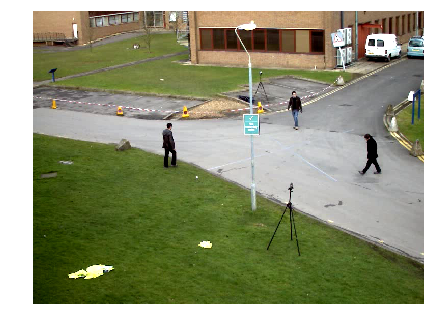

In [9]:
plt.figure(figsize=(7,7))
plt.imshow(cv2.cvtColor(frame,cv2.COLOR_BGR2RGB))
plt.axis('off')

We create a binary foreground mask representing the changed pixels by thresholding the absolute difference between the input and the background frames. Notice that this is performed for all three color channels separately and the pixel is marked as changed if the difference in any channel exceeds the threshold ($T=50$). The result is shown below.

In [10]:
bsub = np.any(abs(frame - backgr) > 50, axis=2)

(-0.5, 767.5, 575.5, -0.5)

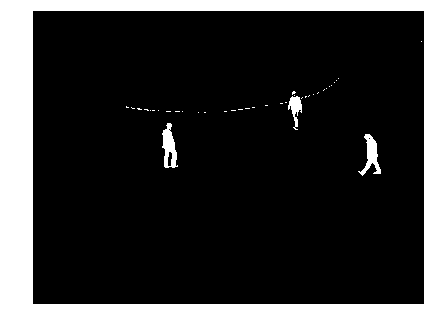

In [11]:
plt.figure(figsize=(7,7))
plt.imshow(bsub.astype(np.uint8)*255, cmap='gray')
plt.axis('off')

The result looks relatively good, but the problem is that our background model is fixed and it does not adapt to changes in the lighting, for example. Also, we have used future frames to create the model that is not possible in realtime applications.

### Gaussian mixture model

Mixture of Gaussians is a simple yet effective way of creating a background model. The implementation in OpenCV updates the model automatically based on every frame that is used as an input. This section has been partly adopted from the OpenCV [tutorial](https://docs.opencv.org/3.4/db/d5c/tutorial_py_bg_subtraction.html).

In [12]:
fgbg = cv2.bgsegm.createBackgroundSubtractorMOG()

In [13]:
fgmask = fgbg.apply(frame)

After the first frame the foreground mask is still empty.

(-0.5, 767.5, 575.5, -0.5)

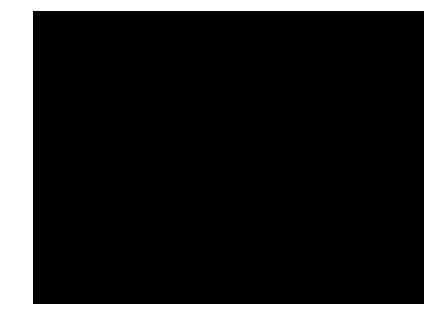

In [14]:
plt.figure(figsize=(7,7))
plt.imshow(fgmask, cmap='gray')
plt.axis('off')

In [15]:
ret, frame = cap.read()

In [16]:
fgmask = fgbg.apply(frame)

But after the second frame we can already see the outline of the moving objects from the mask.

(-0.5, 767.5, 575.5, -0.5)

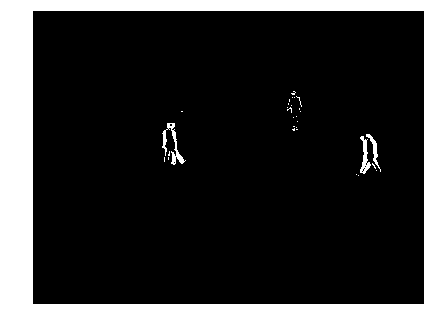

In [17]:
plt.figure(figsize=(7,7))
plt.imshow(fgmask, cmap='gray')
plt.axis('off')

In [18]:
for i in range(20):
    ret, frame = cap.read()
    fgmask = fgbg.apply(frame)

After 20 additional frames the method has already learned the background well.

(-0.5, 767.5, 575.5, -0.5)

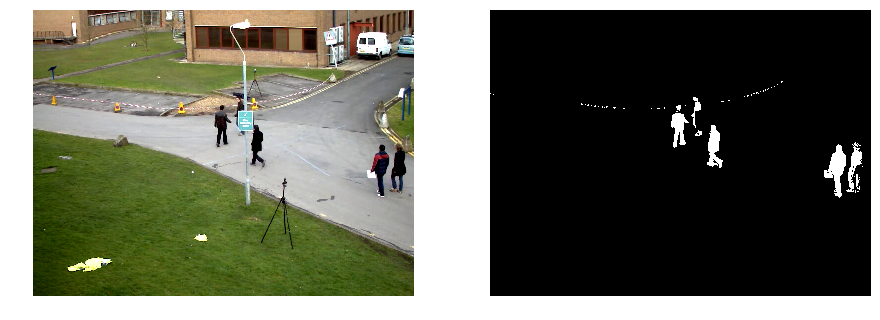

In [19]:
plt.figure(figsize=(15,7))
plt.subplot(121)
plt.imshow(cv2.cvtColor(frame,cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.subplot(122)
plt.imshow(fgmask, cmap='gray')
plt.axis('off')

The result is still quite noisy, but we can use morphological filtering to reduce the noise.

In [20]:
sel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(7,7))
closing = cv2.morphologyEx(fgmask, cv2.MORPH_CLOSE, sel)
sel2 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
opening = cv2.morphologyEx(closing, cv2.MORPH_OPEN, sel2)

(-0.5, 767.5, 575.5, -0.5)

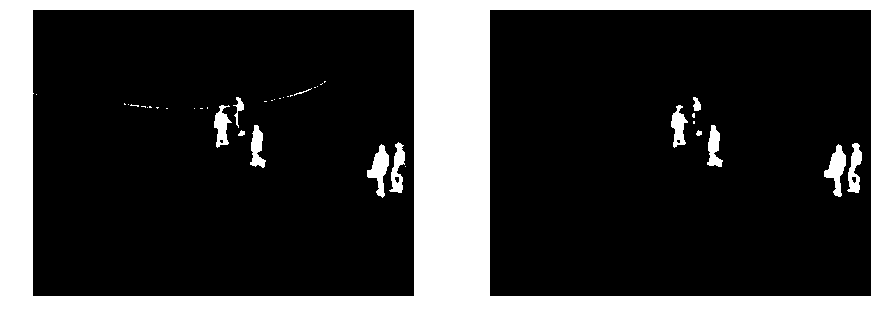

In [21]:
plt.figure(figsize=(15,7))
plt.subplot(121)
plt.imshow(closing, cmap='gray')
plt.axis('off')
plt.subplot(122)
plt.imshow(opening, cmap='gray')
plt.axis('off')

In [22]:
cap.release()

## Feature-based motion estimation
Instead of just detecting the moving objects we are often interested in estimating the 2D motion between image frames. One way of doing it is to extract and match local features as demonstrated in the next example where SIFT features are used.

First, we read and visualize two temporally adjacent frames from a video that are used as input images.

In [23]:
frame1 = cv2.cvtColor(cv2.imread('images/fg1.jpg'), cv2.COLOR_BGR2RGB)
frame2 = cv2.cvtColor(cv2.imread('images/fg2.jpg'), cv2.COLOR_BGR2RGB)

(-0.5, 351.5, 287.5, -0.5)

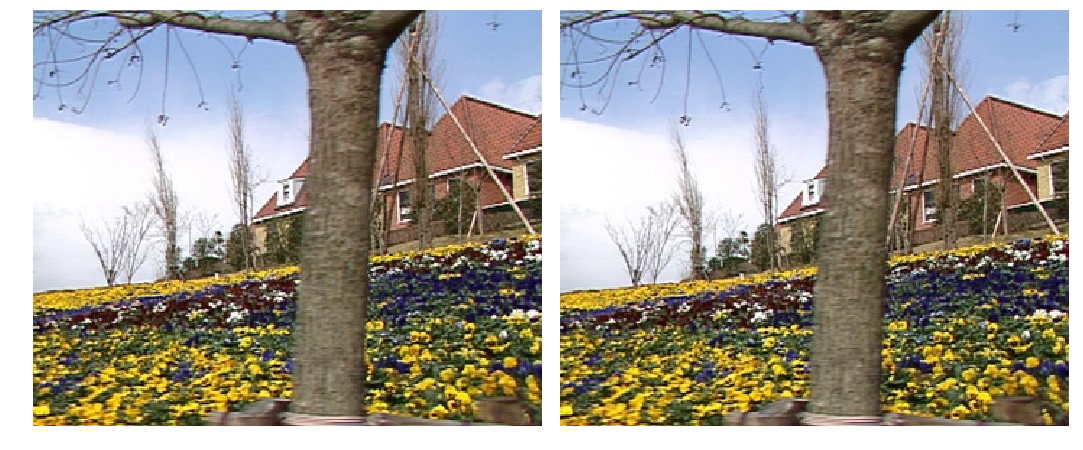

In [24]:
plt.figure(figsize=(15,7))
plt.subplot(121)
plt.tight_layout()
plt.imshow(frame1)
plt.axis('off')
plt.subplot(122)
plt.imshow(frame2)
plt.axis('off')

Next, we extract the SIFT features from the corresponding grayscale images, and match them. Only matches with ratio distance less than 0.5 are accepted to filter out ambiguous matches.

In [25]:
gray1 = cv2.cvtColor(frame1,cv2.COLOR_RGB2GRAY)
gray2 = cv2.cvtColor(frame2,cv2.COLOR_RGB2GRAY)

In [26]:
sift = cv2.xfeatures2d.SIFT_create()

In [27]:
kp1 = sift.detect(gray1,None)
kp2 = sift.detect(gray2,None)

In [28]:
kpp1, desc1 = sift.compute(gray1, kp1)
kpp2, desc2 = sift.compute(gray2, kp2)

In [29]:
bf = cv2.BFMatcher()

In [30]:
matches = bf.knnMatch(desc1,desc2, k=2)

In [31]:
good = []
for m,n in matches:
    if m.distance < 0.5*n.distance:
        good.append([m])

Then we calculate the motion vectors and record their starting points. The sparse motion field obtained is illustrated below.

In [32]:
mv = np.zeros((len(good), 2))
pt = np.zeros((len(good), 2))
for i in range(len(good)):
    i1 = good[i][0].queryIdx
    i2 = good[i][0].trainIdx
    mv[i,:] = np.subtract(kp2[i2].pt,kp1[i1].pt)
    pt[i,:] = kp1[i1].pt

(-0.5, 351.5, 287.5, -0.5)

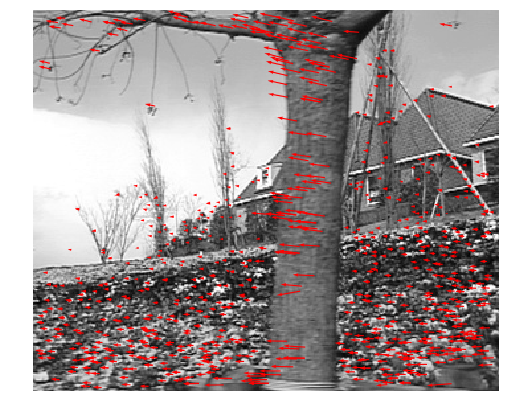

In [33]:
plt.figure(figsize=(15,7))
plt.imshow(gray1, cmap='gray')
plt.quiver(pt[:,0], pt[:,1], mv[:,0], mv[:,1], color='r')
plt.axis('off')

## Lucas-Kanade optical flow

Feature matching is computationally expensive, and often too heavy for motion estimation, because the motion between the frames is limited and the deformations due to geometric or radiometric transformations are quite insignificant. Under these circumstances Lucas-Kanade optical flow provides a simple and computationally efficient approach for sparse motion estimation. Before using it, we need to extract the corner points (similar to Harris corners) that give unambiguous matches between the frames.

In [34]:
lk_params = dict( winSize  = (15,15),
                  maxLevel = 2,
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

In [35]:
pt1 = cv2.goodFeaturesToTrack(gray1, maxCorners=200, qualityLevel=0.3, minDistance=7, blockSize=7)

Then we calculate the Lucas-Kanade optical flow for those points, and visualize the result.

In [36]:
pt2, st, err = cv2.calcOpticalFlowPyrLK(gray1, gray2, pt1, None, **lk_params)

In [37]:
mv_lk = (pt2-pt1).reshape(-1,2)

(-0.5, 351.5, 287.5, -0.5)

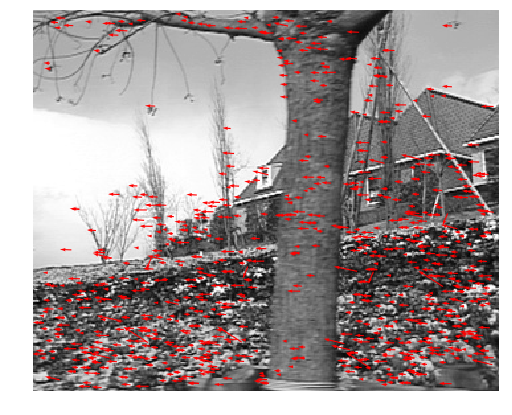

In [38]:
plt.figure(figsize=(15,7))
plt.imshow(gray1, cmap='gray')
plt.quiver(pt[:,0], pt[:,1], mv_lk[:,0], mv_lk[:,1], color='r')
plt.axis('off')

## Dense optical flow

Lucas-Kanade provides only sparse optical flow, but sometimes we need a dense flow field. Because of the aperture problem we need to incorporate some additional constraints (like smoothness) to the optical flow equation. OpenCV includes Farneback's dense optical flow method that is demonstrated next.

In [39]:
flow = cv2.calcOpticalFlowFarneback(gray1,gray2, None, 0.5, 3, 15, 3, 5, 1.2, 0)

(-0.5, 351.5, 287.5, -0.5)

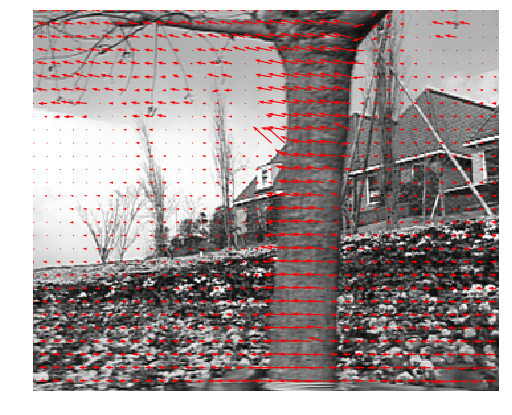

In [40]:
plt.figure(figsize=(15,7))
x, y = np.meshgrid(range(flow.shape[1]),range(flow.shape[0]))
plt.imshow(gray1, cmap='gray')
plt.quiver(x[::10,::10],y[::10,::10],flow[::10,::10,0],flow[::10,::10,1],color='r')
plt.axis('off')

We also visualize the dense optical flow using a pseudo-color representation. The colors are obtained in the HSV color space so that the hue angle encodes the direction of the motion vector and value (intensity) encodes the magnitude.

In [41]:
mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
hsv = np.zeros_like(frame1)
hsv[...,0] = ang*180/np.pi/2
hsv[...,1] = 255
hsv[...,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
img = cv2.cvtColor(hsv,cv2.COLOR_HSV2RGB)

(-0.5, 351.5, 287.5, -0.5)

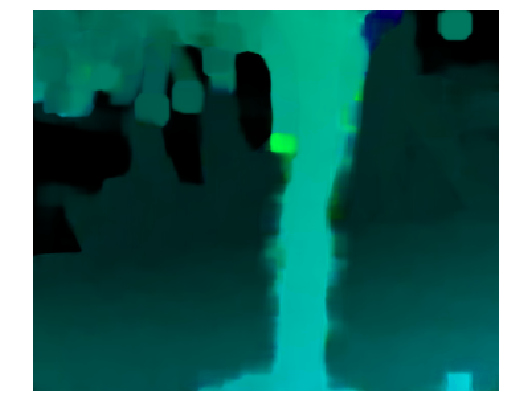

In [42]:
plt.figure(figsize=(15,7))
plt.imshow(img)
plt.axis('off')

## Feature tracking

Finally, we implement a simple feature tracking method that uses the Lucas-Kanade optical flow to establish the correspondences between successive frames. The features are detected once from the first frame, and only those features are continued to be tracked that have a correspondence in all frames.

In [43]:
cap = cv2.VideoCapture('videos/flower_garden_422_cif.y4m')

In [44]:
ret, frame = cap.read()

In [45]:
gray = cv2.cvtColor(frame,cv2.COLOR_RGB2GRAY)
gray0 = gray.copy()

In [46]:
pt = cv2.goodFeaturesToTrack(gray, maxCorners=200, qualityLevel=0.3, minDistance=7, blockSize=7)

In [47]:
num_frames = 100
traj = np.zeros((pt.shape[0],2,num_frames))

In [48]:
traj[:,:,0]=pt.reshape(-1,2)

In [49]:
for i in range(num_frames-1):
    old = gray.copy()
    ret, frame = cap.read()
    gray = cv2.cvtColor(frame,cv2.COLOR_RGB2GRAY)
    pt, st, err = cv2.calcOpticalFlowPyrLK(old, gray, pt, None, **lk_params)
    traj = traj[st.flatten()==1,...]
    pt = pt[st==1]
    traj[:,:,i+1]=pt
    pt = pt.reshape(-1,1,2)

In [50]:
cap.release()

In [51]:
traj.shape

(153, 2, 100)

The feature trajectories obtained are visualized below by overlaying them on the first frame of the video.

(-22.470183801651, 351.5, 287.5, -0.5)

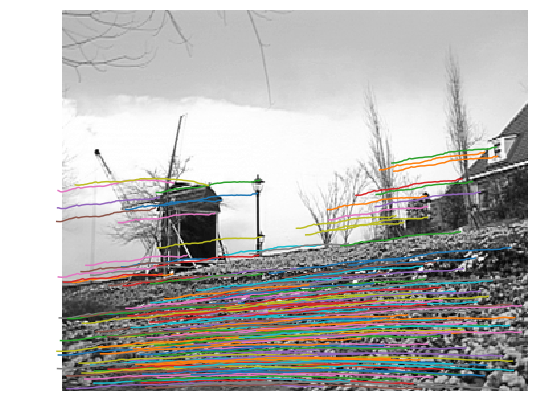

In [52]:
plt.figure(figsize=(15,7))
plt.imshow(gray0, cmap='gray')
plt.plot(traj[:,0,:].T,traj[:,1,:].T)
plt.axis('off')